In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import shutil	
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from google.colab import drive

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import shutil	
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from google.colab import drive


class Trainer():
  def __init__(self, save_location, model, model_name):
    self.dir_location = save_location
    self.model = model
    self.model_name = model_name

  def split_data(self, X_dev, Y_dev, train_size):
    print("SPLITING DATA SET")
    self.X_train, self.X_val, self.Y_train, self.Y_val = train_test_split(X_dev, Y_dev, train_size=train_size)

  def train_model(self, batch_size, epochs, verbose, callbacks):
    print("TRAINING")
    self.model.fit(self.X_train, self.Y_train, batch_size, epochs, verbose, callbacks, validation_data=(self.X_val, self.Y_val))
    self.graph_results()

  def graph_results(self):
    history = self.model.history
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(figsize=(18,12))
    train_ax = ax.scatter(x=range(len(train_acc)), y=train_acc, label="Training Accuracy")
    val_ax = ax.scatter(x=range(len(train_acc)), y=val_acc, label="Validation Accuracy")
    legend = ax.legend()
    fig.suptitle("Min/Max Normalized FCNN Accuracy vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    fig.show()

  def save_model(self):
    drive.mount('/content/drive')
    self.model.save(self.model_name) 
    os.listdir()
    for f in os.listdir(): 
      if (len(f.split(".")) == 1): 
        continue
      if f.split(".")[1] =="h5":
        shutil.copyfile(f, self.dir_location + f)

In [ ]:
# Prepare data
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
from tensorflow.keras.utils import to_categorical
Y_dev_ohe = to_categorical(Y_dev)
Y_test_ohe = to_categorical(Y_test)

print(f"Shape of one-hot encoded labels: {np.shape(Y_dev_ohe)}")
print(f"Min/max values of one-hot encoded labels: {Y_dev_ohe.min()} / {Y_dev_ohe.max()}")

def get_scaled_feature_tensor(x, norm_type=0):
  """Function to get scaled feature matrix. 
    Use norm_type=0 for min,max scaler and norm_type==1 for standard scaler
    TODO: Wrap into model for end-to-end solution 
    TODO: Experiment with normalization over different axis -> eg., Normalization(axis=1) gives normalization by row, axis=2 normalization by column, and axis = 3 normalization by channel. 
  """ 
  if norm_type == 0: 
    scaled_tensor = Rescaling(scale=1.0/255)(x)
  elif norm_type == 1: 
    norm_layer = Normalization(axis=None)
    norm_layer.adapt(x)
    scaled_tensor = norm_layer(x)
  return scaled_tensor

X_norm_min_max = get_scaled_feature_tensor(X_dev, 0)
X_norm_std_scaler = get_scaled_feature_tensor(X_dev, 1)

manual_scaler = [(x-X_dev.mean())/X_dev.std() for x in X_dev[0][0][0]]

# define model
def model(input_shape=(32,32,3), k=10, lr=1e-4, norm_type=0):
  model_input = tf.keras.layers.Input(shape=input_shape)
  norm_input = get_scaled_feature_tensor(model_input, norm_type)
  model_input_flatten = tf.keras.layers.Flatten()(norm_input)
  hidden1 = tf.keras.layers.Dense(64,activation='relu')(model_input_flatten)
  hidden2 = tf.keras.layers.Dense(1024,activation='relu')(hidden1)
  out = tf.keras.layers.Dense(k, activation='softmax')(hidden2)
  model = tf.keras.models.Model(inputs = model_input, outputs =out)
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
  return model  

model1 = model()
model_name_fcn_ = "model1.h5"

# define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
monitor = tf.keras.callbacks.ModelCheckpoint(
    model_name_fcn_, monitor='val_loss',
    verbose=0,save_best_only=True,
    save_weights_only=True,
    mode='min')

# Learning rate schedule
def scheduler(epoch, lr):
  if epoch%100 == 0:
      lr = lr/2
  return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

	

170500096/170498071 [==============================] - 2s 0us/step
Shape of one-hot encoded labels: (50000, 10)
Min/max values of one-hot encoded labels: 0.0 / 1.0


SPLITING DATA SET
TRAINING
1250/1250 [==============================] - 7s 5ms/step - loss: 2.3000 - accuracy: 0.1235 - val_loss: 2.2833 - val_accuracy: 0.1500
Mounted at /content/drive


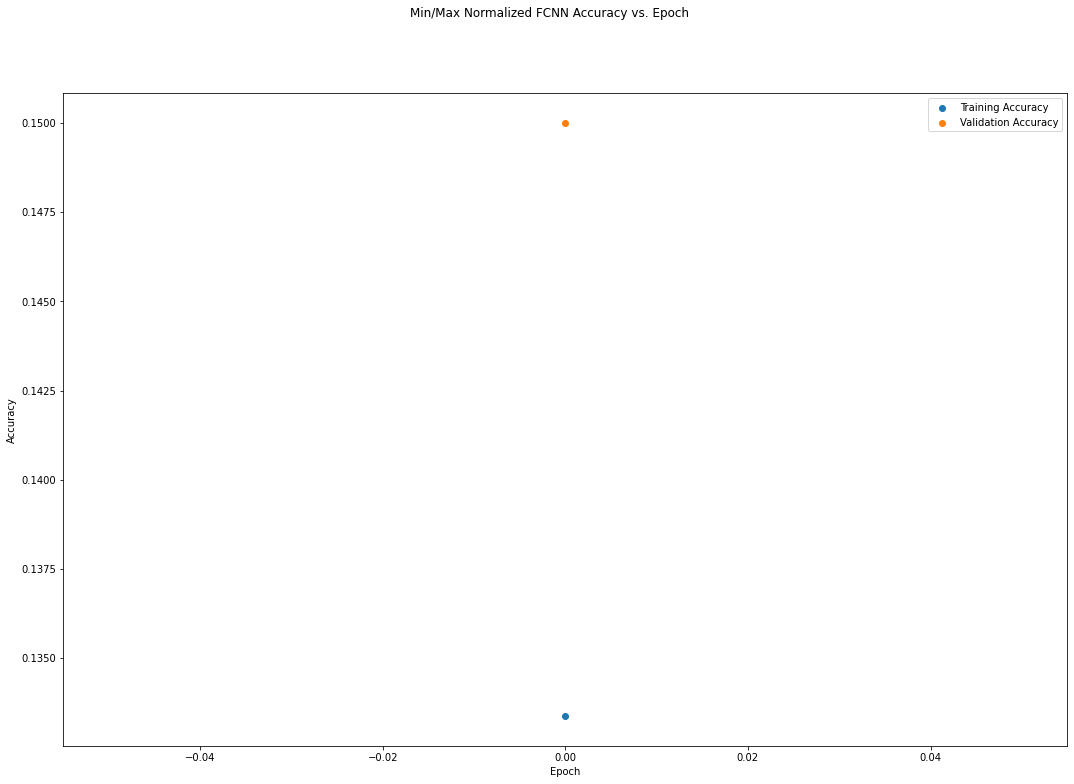

In [ ]:
arnold = Trainer(save_location="./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/", model=model1, model_name=model_name_fcn_)
arnold.split_data(X_dev=X_dev, Y_dev=Y_dev_ohe, train_size=0.8)
arnold.train_model(batch_size=32, epochs=1, verbose=1, callbacks=[early_stop, monitor, lr_schedule])
arnold.save_model()

